In [ ]:
%load_ext autoreload
%autoreload 2

In [149]:
import pickle


with open('dataset/REALSum/REALSumm/scores_dicts/abs.pkl', 'rb') as f:
    data_abs = pickle.load(f)

with open('dataset/REALSum/REALSumm/scores_dicts/ext.pkl', 'rb') as f:
    data_ext = pickle.load(f)

In [160]:
data_abs

{52: {'doc_id': 52,
  'ref_summ': "<t> manchester united take on manchester city on sunday . </t>  <t> match will begin at 4pm local time at united 's old trafford home . </t>  <t> police have no objections to kick-off being so late in the afternoon . </t>  <t> last late afternoon weekend kick-off in the manchester derby saw 34 fans arrested at wembley in 2011 fa cup semi-final . </t>",
  'system_summaries': {'presumm_out_trans_abs.txt': {'system_summary': '<t> manchester derby takes place at old trafford on sunday afternoon </t>  <t> police have no objections to the late afternoon kick-off </t>  <t> both sides are challenging for a top-four spot in the premier league </t>  <t> the man in charge of patrolling the sell-out clash has no such fears </t>',
    'scores': {'rouge_1_f_score': 0.42719,
     'rouge_2_recall': 0.18182,
     'rouge_l_recall': 0.39286,
     'rouge_2_precision': 0.21739,
     'rouge_2_f_score': 0.19802,
     'rouge_1_precision': 0.46809,
     'rouge_1_recall': 0.39

In [157]:
# import pandas as pd

# df_abs = pd.concat({k: pd.DataFrame(v).T for k, v in data_abs.items()}, axis=0)
# df_ext = pd.concat({k: pd.DataFrame(v).T for k, v in data_ext.items()}, axis=0)

# df_abs.to_excel('analytics/REALSumm_abs.xlsx')
# df_ext.to_excel('analytics/REALSumm_ext.xlsx')


In [4]:
import json

def load_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            # Parse each line as a JSON object
            json_line = json.loads(line)
            data.append(json_line)
    return data

# Load your data
file_path = 'dataset/SumEval/M22/aligned/outputs_cnndm.aligned.jsonl'  # Replace with the path to your .jsonl file
data_m22 = load_jsonl(file_path)

In [5]:
# Example of accessing the data
for item in data_m22[:2]:  # Just print the first 2 summaries for demonstration
    print("Reference Summary:", item['reference'])
    print("Decoded Summary:", item['decoded'])
    print("---")

Reference Summary: Marseille prosecutor says `` so far no videos were used in the crash investigation '' despite media reports . Journalists at Bild and Paris Match are `` very confident '' the video clip is real , an editor says . Andreas Lubitz had informed his Lufthansa training school of an episode of severe depression , airline says .
Decoded Summary: A French prosecutor says he is not aware of any video footage from on board the plane . German daily Bild and Paris Match claim to have found a cell phone video of the crash . A French Gendarmerie spokesman calls the reports `` completely wrong '' and `` unwarranted ''
---
Reference Summary: Membership gives the ICC jurisdiction over alleged crimes committed in Palestinian territories since last June . Israel and the United States opposed the move , which could open the door to war crimes investigations against Israelis .
Decoded Summary: The Palestinian Authority becomes the 123rd member of the International Criminal Court . The for

# Scores

In [21]:
reference = "This is a reference text example."
candidate = "This is a candidate text example."

# BLEU

In [26]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def BLEU__(reference, candidate):
    reference_tokens = [reference.split()]  # BLEU expects a list of reference lists
    candidate_tokens = candidate.split()  # Candidate is a list of tokens
    # Use smoothing function for cases of perfect matches and zero matches
    smoothing_function = SmoothingFunction().method2
    # Calculate BLEU score
    score = corpus_bleu([reference_tokens], [candidate_tokens], smoothing_function=smoothing_function)
    return score

BLEU__(reference, candidate)

0.48549177170732344

# ROUGE

In [27]:
from rouge import Rouge

def ROUGE__(reference, candidate):
    rouge = Rouge()
    scores = rouge.get_scores(candidate, reference)
    return scores[0]

ROUGE__(reference, candidate)

{'rouge-1': {'r': 0.8333333333333334,
  'p': 0.8333333333333334,
  'f': 0.8333333283333335},
 'rouge-2': {'r': 0.6, 'p': 0.6, 'f': 0.5999999950000001},
 'rouge-l': {'r': 0.8333333333333334,
  'p': 0.8333333333333334,
  'f': 0.8333333283333335}}

# BERT Score

In [28]:
from bert_score import BERTScorer


bert_scorer = BERTScorer(model_type='bert-base-uncased')


def BERT_SCORE__(reference, candidate):
    P, R, F1 = bert_scorer.score([candidate], [reference])
    return {'P': P.mean().item(), 'R': R.mean().item(), 'F1': F1.mean().item()}


BERT_SCORE__(reference, candidate)

{'P': 0.9258394837379456, 'R': 0.9258394837379456, 'F1': 0.9258394837379456}

# Mover Score

In [40]:
from typing import List
import moverscore_v2
from collections import defaultdict
import numpy as np


def MOVER_SCORE__(hypothesis, references):

    idf_dict_hyp = defaultdict(lambda: 1.)
    idf_dict_ref = defaultdict(lambda: 1.)

    sentence_score = 0 

    scores = moverscore_v2.word_mover_score([references], hypothesis, idf_dict_ref, idf_dict_hyp, stop_words=[], n_gram=1, remove_subwords=False, device='cpu')

    sentence_score = np.mean(scores)

    return sentence_score


MOVER_SCORE__(reference, candidate)

AttributeError: 'DistilBertTokenizer' object has no attribute 'max_len'

# Compare metrics

In [140]:
import progressbar



def compare_metrics(data, metrics):
    bar = progressbar.ProgressBar(maxval=len(data)).start()
    bar_idx = 0

    results = []

    for item in data:
        metrics_results = {}

        for metric in metrics:
            score = metric(item['reference'], item['decoded'])
            metrics_results[metric.__name__] = score
    
        results.append(metrics_results)

        bar.update(bar_idx)
        bar_idx += 1

    return results


results = compare_metrics(data_m22, [BLEU__, ROUGE__, BERT_SCORE__])

In [143]:
results[0]

{'BLEU__': 0.08987677250848447,
 'ROUGE__': {'rouge-1': {'r': 0.2978723404255319,
   'p': 0.35,
   'f': 0.321839075492139},
  'rouge-2': {'r': 0.09259259259259259,
   'p': 0.10638297872340426,
   'f': 0.09900989601411651},
  'rouge-l': {'r': 0.2765957446808511, 'p': 0.325, 'f': 0.2988505697450126}},
 'BERT_SCORE__': {'P': 0.6378241777420044,
  'R': 0.6159521341323853,
  'F1': 0.6266974210739136}}

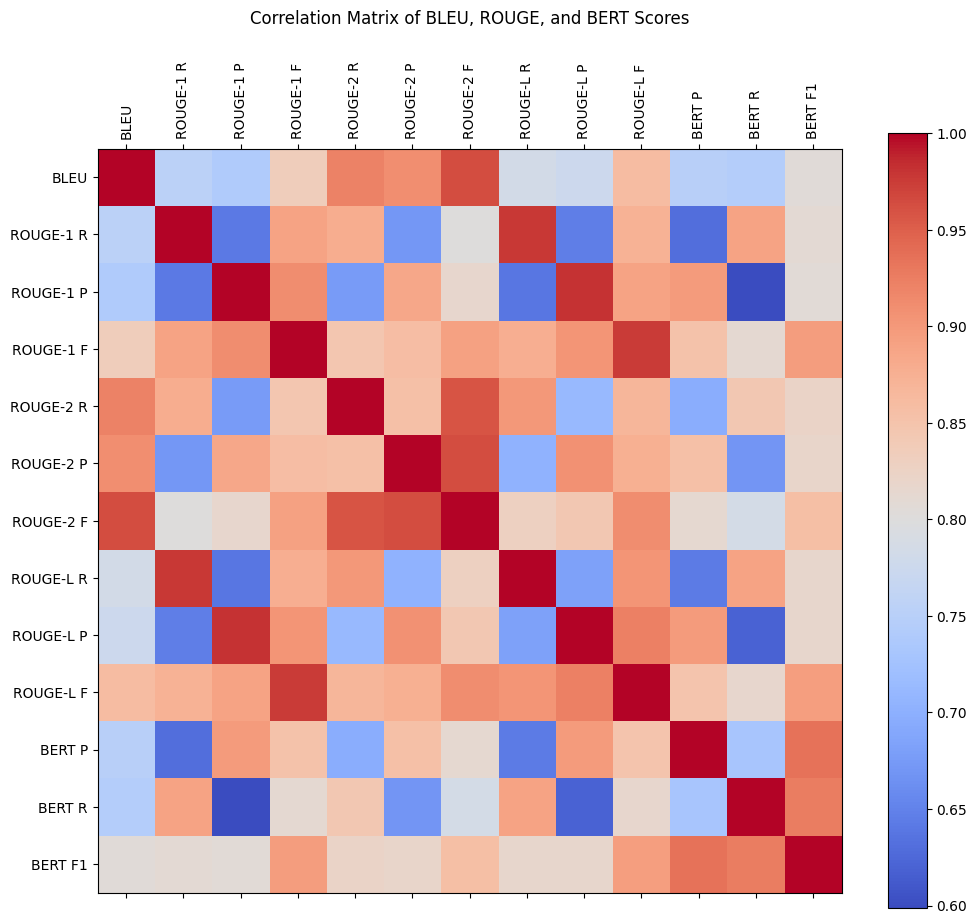

In [147]:
# from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt


# BLEU score
bleu_scores = [result['BLEU__'] for result in results]

# ROUGE scores
rouge_1_recall = [result['ROUGE__']['rouge-1']['r'] for result in results]
rouge_1_precision = [result['ROUGE__']['rouge-1']['p'] for result in results]
rouge_1_f1 = [result['ROUGE__']['rouge-1']['f'] for result in results]

rouge_2_recall = [result['ROUGE__']['rouge-2']['r'] for result in results]
rouge_2_precision = [result['ROUGE__']['rouge-2']['p'] for result in results]
rouge_2_f1 = [result['ROUGE__']['rouge-2']['f'] for result in results]

rouge_l_recall = [result['ROUGE__']['rouge-l']['r'] for result in results]
rouge_l_precision = [result['ROUGE__']['rouge-l']['p'] for result in results]
rouge_l_f1 = [result['ROUGE__']['rouge-l']['f'] for result in results]

# BERT scores
bert_p = [result['BERT_SCORE__']['P'] for result in results]
bert_r = [result['BERT_SCORE__']['R'] for result in results]
bert_f1 = [result['BERT_SCORE__']['F1'] for result in results]

# Combine all scores into a single matrix for correlation analysis
scores_matrix = np.array([
    bleu_scores,
    rouge_1_recall, rouge_1_precision, rouge_1_f1,
    rouge_2_recall, rouge_2_precision, rouge_2_f1,
    rouge_l_recall, rouge_l_precision, rouge_l_f1,
    bert_p, bert_r, bert_f1
])

correlation_matrix = np.corrcoef(scores_matrix)


# Labels for each score in the matrix
labels = [
    'BLEU',
    'ROUGE-1 R', 'ROUGE-1 P', 'ROUGE-1 F',
    'ROUGE-2 R', 'ROUGE-2 P', 'ROUGE-2 F',
    'ROUGE-L R', 'ROUGE-L P', 'ROUGE-L F',
    'BERT P', 'BERT R', 'BERT F1'
]

plt.figure(figsize=(12, 10))
plt.matshow(correlation_matrix, fignum=1, cmap='coolwarm')
plt.xticks(range(len(labels)), labels, rotation=90)
plt.yticks(range(len(labels)), labels)

# Add color bar to make interpretation easier
plt.colorbar()
plt.title('Correlation Matrix of BLEU, ROUGE, and BERT Scores', pad=90)

plt.show()


# Custom metric V1

In [102]:
from transformers import AutoModel, AutoTokenizer, DistilBertModel, DistilBertTokenizer, DistilBertConfig
import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sentence_transformers import SentenceTransformer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Load English stop words
stop_words = set(stopwords.words('english'))


# ess_model = SentenceTransformer('LaBSE')


model_name = "bert-large-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()



[nltk_data] Downloading package stopwords to /home/alexey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
loading configuration file config.json from cache at /home/alexey/.cache/huggingface/hub/models--bert-large-uncased/snapshots/6da4b6a26a1877e173fca3225479512db81a5e5b/config.json
Model config BertConfig {
  "_name_or_path": "bert-large-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.38.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cach

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-23): 24 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inpl

In [132]:
import string


test_text_1 = '''This is a test text for custom metric version 2.
We use here clusters of embeddings with customizable angles as thresholds.
We test it with BERT tokenizer.
We use cosine similarity to find clusters based on the angle in an n-sphere.'''

test_text_ref = '''Marseille prosecutor says `` so far no videos were used in the crash investigation '' despite media reports . Journalists at Bild and Paris Match are `` very confident '' the video clip is real , an editor says . Andreas Lubitz had informed his Lufthansa training school of an episode of severe depression , airline says .'''
test_text_sum = '''A French prosecutor says he is not aware of any video footage from on board the plane . German daily Bild and Paris Match claim to have found a cell phone video of the crash . A French Gendarmerie spokesman calls the reports `` completely wrong '' and `` unwarranted '''''

def get_bert_embeddings(text, tokenizer, model):
    # Tokenize input text and prepare input tensors
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    
    # Forward pass, get model outputs
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Extract embeddings
    embeddings = outputs.last_hidden_state
    return embeddings[0]


def tokenize_and_get_words_1(text, tokenizer, model):
    # Tokenize input text and prepare input tensors
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    input_ids = inputs["input_ids"]
    
    # Convert input IDs to list of words/tokens
    tokens = [tokenizer.convert_ids_to_tokens(idx) for idx in input_ids.tolist()[0]]
    
    # Forward pass to get embeddings
    with torch.no_grad():
        outputs = model(**inputs)
    
    embeddings = outputs.last_hidden_state.squeeze(0)  # Remove batch dimension
    
    return tokens, embeddings


def tokenize_and_get_words_2(text, tokenizer, model):
    # Tokenize input text and prepare input tensors
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    input_ids = inputs["input_ids"]
    
    # Convert input IDs to list of words/tokens
    tokens = [tokenizer.convert_ids_to_tokens(idx) for idx in input_ids.tolist()[0]]
    
    # Filter out stop words and punctuation
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)
    
    filtered_tokens = []
    filtered_indices = []
    
    for i, token in enumerate(tokens):
        # Remove '##' used by BERT for subwords
        clean_token = token.replace("##", "")
        if clean_token not in stop_words and clean_token not in punctuation:
            filtered_tokens.append(token)
            filtered_indices.append(i)
    
    # Forward pass to get embeddings
    with torch.no_grad():
        outputs = model(**inputs)
    
    embeddings = outputs.last_hidden_state.squeeze(0)  # Remove batch dimension
    
    # filtered_tokens = list(set(filtered_tokens))

    # Filter embeddings to only include those that correspond to filtered_tokens
    filtered_embeddings = embeddings[filtered_indices]
    
    return filtered_tokens, filtered_embeddings


def find_clusters(embeddings, sim_threshold=0.8):
    # Compute cosine similarity matrix
    cos_sim_matrix = cosine_similarity(embeddings, embeddings)
    
    # Cluster embeddings based on cosine similarity threshold
    clusters = []
    for i, embedding in enumerate(embeddings):
        in_cluster = [j for j, sim in enumerate(cos_sim_matrix[i]) if sim > sim_threshold]
        clusters.append(in_cluster)
    
    return clusters, cos_sim_matrix


def score_v1(text, sim_threshold=0.8):
    tokens, embeddings = tokenize_and_get_words_2(text, tokenizer, model)
    clusters, cos_sim_matrix = find_clusters(embeddings, sim_threshold)
    word_clusters = clusters_to_words(clusters, tokens)
    return word_clusters, clusters, cos_sim_matrix, tokens


def clusters_to_words(clusters, tokens):
    words_clusters = []
    for cluster in clusters:
        # Map each token ID in the cluster to its corresponding word
        words = [tokens[i] for i in cluster]
        words_clusters.append(words)
    return words_clusters


word_clusters_1, clusters_1, cos_sim_matrix_1, tokens_1 = score_v1(test_text_1)
word_clusters_ref, clusters_ref, cos_sim_matrix_ref, tokens_ref = score_v1(test_text_ref)
word_clusters_sum, clusters_sum, cos_sim_matrix_sum, tokens_sum = score_v1(test_text_sum)

# word_clusters

In [87]:
import matplotlib.pyplot as plt

def plot_cosine_similarity_matrix(cos_sim_matrix, tokens, name=None):
    fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as needed
    cax = ax.matshow(cos_sim_matrix, cmap='coolwarm')
    
    # Set ticks and labels
    ax.set_xticks(range(len(tokens)))
    ax.set_yticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=90)
    ax.set_yticklabels(tokens)
    
    # Set labels for clarity
    ax.set_xlabel('Tokens')
    ax.set_ylabel('Tokens')
    ax.set_title('Cosine Similarity Matrix')
    
    # Add colorbar to interpret the colors
    fig.colorbar(cax)

    if name is not None:
        fig.savefig('embed_sim_'+name+'.png')

    plt.show()

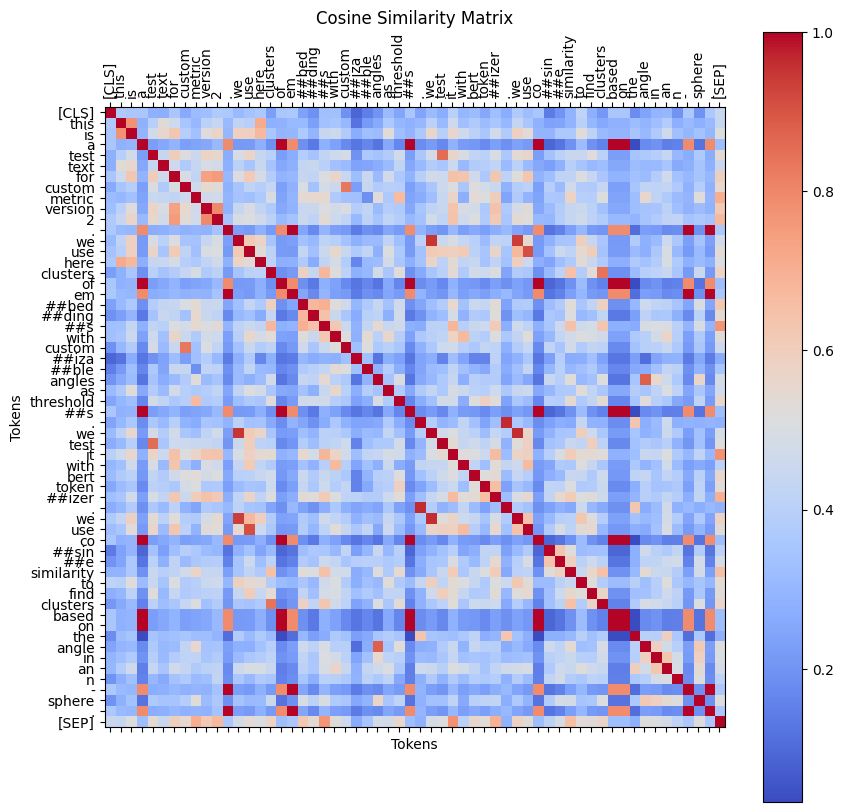

In [88]:
plot_cosine_similarity_matrix(cos_sim_matrix_1, tokens_1)

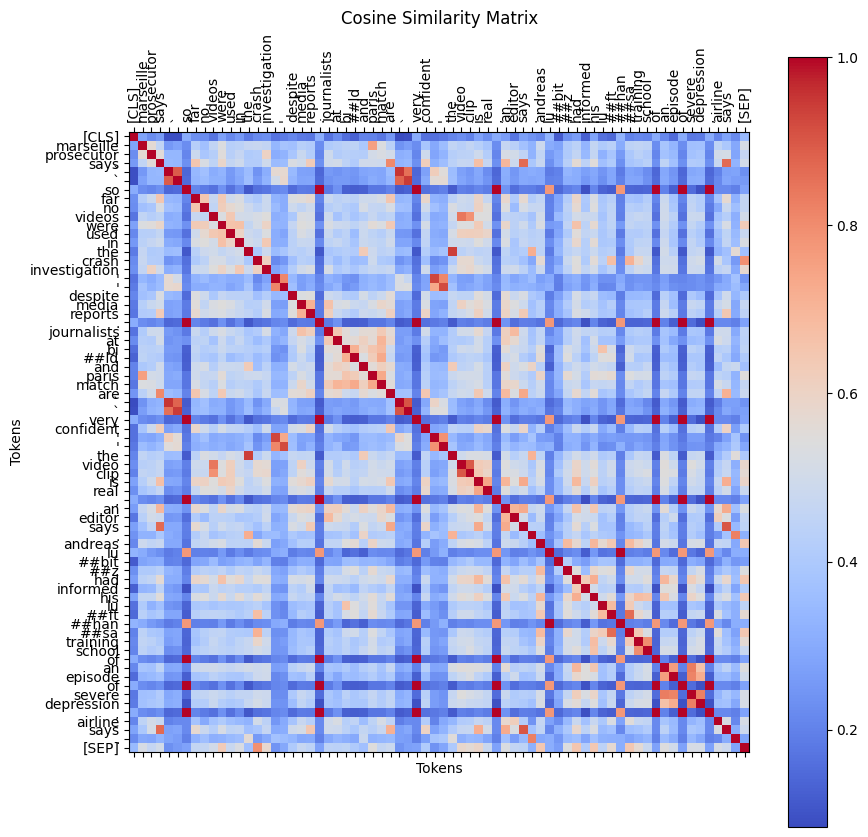

In [89]:
plot_cosine_similarity_matrix(cos_sim_matrix_ref, tokens_ref, 'ref')

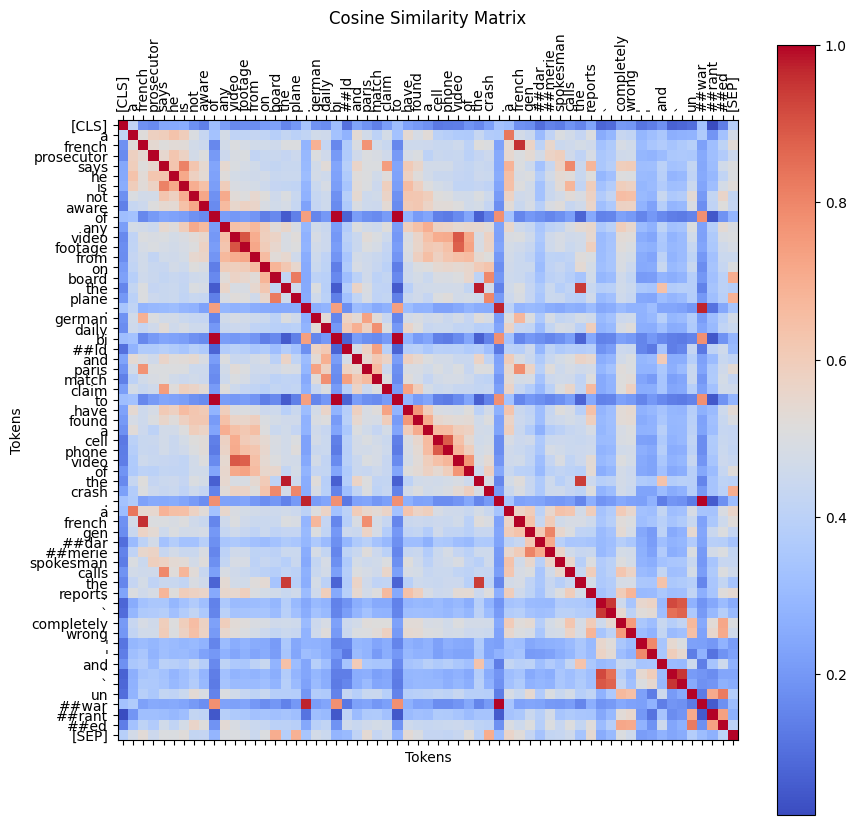

In [90]:
plot_cosine_similarity_matrix(cos_sim_matrix_sum, tokens_sum, 'sum')

In [134]:
test_text_sum_2_1 = 'The paper, titled "Scaling Rectified Flow Transformers for High-Resolution Image Synthesis," presents advancements in generative modeling for high-dimensional perceptual data such as images and videos. It introduces a novel approach to train rectified flow models, aiming at better capturing perceptually relevant features. A significant contribution is a transformer-based architecture for text-to-image generation that separates weights for image and text modalities, enhancing text understanding and visual quality. This architecture demonstrates scalable improvements in text-to-image synthesis, outperforming current models. The authors will make their data, code, and model weights publicly available for further research​'
test_text_sum_2_2 = 'The paper titled "Scaling Rectified Flow Transformers for High-Resolution Image Synthesis" introduces an advanced generative model formulation known as rectified flow, which linearly connects data and noise. This work enhances noise sampling techniques for training rectified flow models, focusing on perceptually relevant scales, leading to superior performance in high-resolution text-to-image synthesis. A novel transformer-based architecture is presented for this purpose, featuring separate weights for image and text modalities to enable a bidirectional information flow, thus improving text comprehension and aesthetics in generated images. The study shows that this approach follows predictable scaling trends, correlating lower validation loss with better synthesis quality, outperforming state-of-the-art models. The authors promise to make their experimental data, code, and model weights publicly available.'

word_clusters_sum_2_1, clusters_sum_2_1, cos_sim_matrix_sum_2_1, tokens_sum_2_1 = score_v1(test_text_sum_2_1, 0.6)
word_clusters_sum_2_2, clusters_sum_2_2, cos_sim_matrix_sum_2_2, tokens_sum_2_2 = score_v1(test_text_sum_2_2, 0.6)

# plot_cosine_similarity_matrix(cos_sim_matrix_sum_2_1, tokens_sum_2_1, 'sum_2_1')
# plot_cosine_similarity_matrix(cos_sim_matrix_sum_2_2, tokens_sum_2_2, 'sum_2_2')




# def unique_ll(list_list):
#     unique = set()
#     for list1 in list_list:
#         unique.add(tuple(list1))
#     return list(unique)

# word_clusters_sum_2_1 = unique_ll(word_clusters_sum_2_1)
# word_clusters_sum_2_2 = unique_ll(word_clusters_sum_2_2)


word_clusters_sum_2_1.sort(key = lambda x: len(x))
word_clusters_sum_2_2.sort(key = lambda x: len(x))


with open('sum_2_word_clusters.txt', 'a') as file:
    for w21 in word_clusters_sum_2_1:
        file.write(f'{w21}\n')
    file.write('\n')
    for w22 in word_clusters_sum_2_2:
        file.write(f'{w22}\n')
    file.write('\n\n')